In [6]:
import numpy as np
import math as mt 
import scipy.optimize as opt
import scipy.stats as sta
import matplotlib.pyplot as plt
from scipy import optimize, interpolate, linalg
import csv

In [7]:
def convertF(items):
    ## convert string of measurements to float
    for i,a in enumerate(items):
        if i < 2:   ## start from the 3rd item: x
            continue
        try:
            a=float(a)
        except ValueError:
            return 0    
    return 1
    
def GetEntries(filename):
    #Read the CSV file and import the data into a corresponding list
    ID = []
    cubeNo = []
    meas_x = []
    meas_y = []
    meas_z = []
    meas_v = []
    unc_x = []
    unc_y = []
    unc_z = []
    unc_v = []
    
    with open(filename) as cubedata:
        entries = csv.reader(cubedata, delimiter=',')
        for row in entries:
            ## if there is any invalid entry in a row, then skip this row
            valid_item = convertF(row)
            if not valid_item:
                continue;
                
            ID.append(row[0])
            cubeNo.append(int(row[1]))
            meas_x.append(float(row[2]))
            meas_y.append(float(row[4]))
            meas_z.append(float(row[6]))
            meas_v.append(float(row[8]))
            unc_x.append(float(row[3]))
            unc_y.append(float(row[5]))
            unc_z.append(float(row[7]))
            unc_v.append(float(row[9]))
        
    return ID, cubeNo, meas_x, meas_y, meas_z, meas_v, unc_x, unc_y, unc_z, unc_v

In [8]:
def calculate_average(values): 
    sumtot = sum(values)
    avg = sumtot / len(values)
    return avg 

def calculate_variance(values):
    avg = calculate_average(values)
    variance = 0
    for val in values:
        variance += (val - avg) ** 2 
    return variance / (len(values) - 1)

def calculate_stdev(values):
    return np.sqrt(calculate_variance(values))


#some other functions
def Incorrect_V(ID,x,y,z,v):
    #Spot out the incorrect calculation of V
    list_incorrection = []
    for i, vi in enumerate(v):
        v_cal = x[i] * y[i] * z[i]
        if mt.fabs(v_cal - vi) > 0.001 * v_cal: ## Pick out cases where reported V deviated from calculated by 0.1%
            #print("{}: {} :\t x={},y={},z={} \t reported V: {} \t calculated V: {:.1f}".format(i,ID[i],x[i],y[i],z[i],v[i],v_cal) )
            list_incorrection.append(i)
    return list_incorrection
            
def gaussian(x,pars):
    #Python has built-in Norm(Gaussian) function. Anyway we can build our own to compare 
    return pars[0] * (1 / (np.sqrt(2 * np.pi * np.power(pars[2], 2)))) * \
    (np.power(np.e, -(np.power((x - pars[1]), 2) / (2 * np.power(pars[2], 2)))))

In [19]:
ID, cubeNo, meas_x, meas_y, meas_z, meas_v, unc_x, unc_y, unc_z, unc_v = GetEntries("cubeData.csv")
incorrections = Incorrect_V(ID,meas_x,meas_y,meas_z,meas_v)

## filter out the outliers/incorrectly calculated V
data = list(meas_v)  # copy the list
for index in incorrections[::-1]:  ## [::-1] to reverse the list of the outlier index
    del data[index]

print(str(len(data)))
## Bin data
num_bins = int(len(data) / 40)   ## choose your own
bins = np.linspace(min(data), max(data), num_bins+1)
hist, bin_edges = np.histogram(data, bins)
bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
binwidth = (max(data) - min(data))/num_bins
print(str(binwidth))
print(str(num_bins))

263
210.5625
6


In [10]:
def Residuals(pars):
    estimation = gaussian(bin_centers, pars)
    residuals = (estimation - hist)/np.sqrt(hist)
    redisuals_without_nans = residuals[~np.isnan(residuals)]
    return redisuals_without_nans

def Chi2(pars):
    return np.sum(Residuals(pars) ** 2)


def Getfit(result):
    ## read out the fitted parameters and their uncertainties
    estimates = result.x
    jacobian = result.jac
    
    covariance_inv = np.dot(jacobian.T, jacobian)
    covariance = linalg.inv(covariance_inv)

    ## uncertainties are the diagonal terms of the covariance matrix
    errors = np.sqrt(np.diagonal(covariance))

    return estimates,covariance,errors

In [11]:
## Perform the fit
init_par = [len(data)*binwidth,calculate_average(data),calculate_stdev(data)]
result = opt.least_squares(Residuals, init_par)

paras, cov, errs = Getfit(result)

print("Fitting Results:")
print("Norm \t= {:.2f}±{:.2f}".format(paras[0], errs[0]))
print("mu \t= {:.2f}±{:.2f}".format(paras[1], errs[1]))
print("sigma \t= {:.2f}±{:.2f}".format(paras[2], errs[2]))

#print("Minimal Chi2:")
#print (Chi2(paras))
print("Reduced Chi2:")
print ("{:.2f}/({}-{}) = {}".format(Chi2(paras),num_bins, 3, Chi2(paras)/(num_bins-3)))

Fitting Results:
Norm 	= 53670.16±3360.67
mu 	= 3408.10±8.38
sigma 	= 133.11±6.21
Reduced Chi2:
7.94/(6-3) = 2.6465049156872156


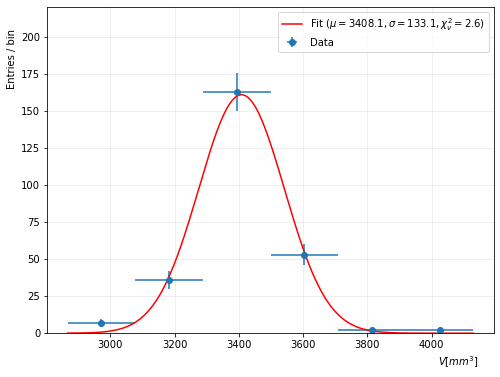

In [13]:
## Plot
plt.figure(figsize=(8, 6))
# plt.style.use('mystyle.mplstyle')
    
## Plot data
xrr = binwidth/2.0
yrr = np.sqrt(hist)
plt.errorbar(bin_centers, hist, xerr=xrr, yerr=yrr, label='Data',fmt='o')


## plot gaussian
gau_x = np.linspace(min(data),  max(data), 1000)
plt.plot(gau_x, gaussian(gau_x,paras), color = 'r', label="Fit ($\mu={:.1f},\sigma={:.1f},\chi^2_\\nu={:.1f}$)".format(paras[1],paras[2],Chi2(paras)/(num_bins-3))) ## plot gaussian

##title, label and set the x,y range as you like
plt.ylabel('Entries / bin',position=(0.1,0.84))
plt.xlabel('$V[mm^3]$',position=(0.92,0.1))
#plt.xlim(lower_edge, upper_edge)
plt.ylim(0, 1.35*hist.max())  ## usually plot the upper range of y-axis a little bit larger than the max of the histograms to allow room for legends
plt.grid(True, alpha=0.25) 
plt.legend(loc='best')

In [14]:
labels = ["Norm", "$\mu$", "$\sigma$"]

def Contour_2D(result, indices, colors=plt.cm.Blues):
    estimates, covariance, errors = Getfit(result)
    i, j = indices
    marginalized_covariance = covariance[[i, j], :][:, [i, j]] 
    
    # Create a confidence interval grid
    xerr, yerr = np.sqrt(np.diagonal(marginalized_covariance))
    delta_x, delta_y = np.meshgrid(np.linspace(-3 * xerr, 3 * xerr, 100),
                                        np.linspace(-3 * yerr, 3 * yerr, 100))
    
    # Find and plot how far each point is from the estimates
    nsigmas = np.array([[ np.sqrt(np.dot(np.dot([delta_x[ii, jj], delta_y[ii, jj]], np.linalg.inv(marginalized_covariance)),
                         [delta_x[ii, jj], delta_y[ii, jj]]))
                       for ii in range(len(delta_x)) ] for jj in range(len(delta_y)) ])

    plt.xlabel(labels[i])
    plt.ylabel(labels[j])
    plt.contourf(
        estimates[i] + delta_x, estimates[j] + delta_y,
        -nsigmas, # Negative sign just to reverse the colormap.
        levels=-np.array([-0.1, 1, 2, 3])[::-1], cmap=colors, alpha=0.7
    )
    
def Distribution_1D(result, indices):
    estimates, covariance, errors = Getfit(result)    

    delta = np.linspace(-3 * errors[indices], 3 * errors[indices], 100)
    chi2_vary = np.zeros(100)
    
    parameter = estimates.copy()
    for ii, vary in enumerate(estimates[indices] + delta):
        parameter[indices] = vary
        chi2_vary[ii] = Chi2(parameter)

    plt.xlabel(labels[indices])
    plt.ylabel("$\chi^2$")
    plt.grid(True, alpha=0.25)
    plt.plot(estimates[indices] + delta, chi2_vary)

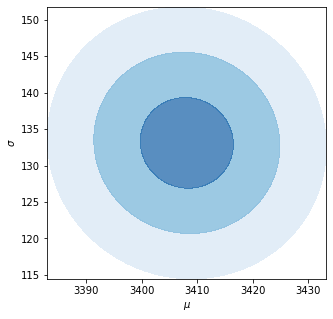

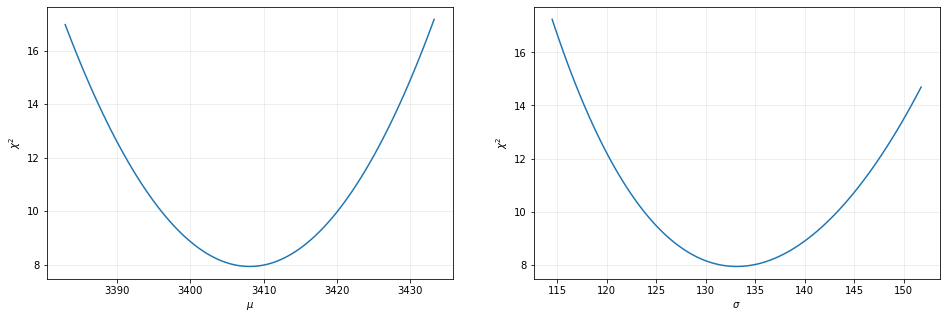

In [15]:
plt.figure(figsize=(5, 5))
Contour_2D(result, [1,2])

plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
Distribution_1D(result, 1)
plt.subplot(1, 2, 2)
Distribution_1D(result, 2)